In [1]:
## Import dependencies
import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 500

# Identification part of the filenames
model_base_name = '250000spec_8Metabolites_RAE_ExtendedRange_MoreLeftOut_Combined1Distribution_OptParams'
base_name = '250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name

## Train CNN on dataset of 8 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"CNN_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [4]:
# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra_filename = f'Dataset8_{base_name}_ForManuscript_Spec.dat'
conc1_filename = f'Dataset8_{base_name}_ForManuscript_Conc.npy'

spectra_shape = (249996, 46000)
conc1_shape = (249996, 8)


# Load the memmap arrays
spectra_memmap = np.memmap(spectra_filename, dtype=np.float64, mode='r', shape=spectra_shape)
conc1_memmap = np.load(conc1_filename)

# Split into testing and training data
X_train_indices, X_test_indices, y_train_indices, y_test_indices = train_test_split(
    np.arange(spectra_shape[0]), np.arange(conc1_shape[0]), test_size=0.2, random_state=1
)

# Create custom dataset class
class NMRDataset(torch.utils.data.Dataset):
    def __init__(self, spectra_memmap, conc1_memmap, indices):
        self.spectra_memmap = spectra_memmap
        self.conc1_memmap = conc1_memmap
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        X = self.spectra_memmap[actual_idx]
        y = self.conc1_memmap[actual_idx]
        return torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
    

# Create datasets
train_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_train_indices)
test_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_test_indices)


# Create DataLoaders
batch_size = 16  
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
## Define NN model object, define some parameters, and instantiate model

## Best parameters determined in Optuna study
#{'num_conv_layers': 3, 
# 'kernel_size': 10, 
# 'num_channels': 35, 
# 'pooling_type': 'none', 
# 'conv_stride': 4, 
# 'feedforward_size': 233, 
# 'learning_rate': 2.067749078763321e-05, 
# 'reg_strength': 0.004990448395463014, 
# 'bs': 16}


# Define some model & training parameters
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super(NMR_Model_Aq, self).__init__()
        self.conv1 = nn.Conv1d(1, 35, kernel_size=10, stride=4, padding=1)
        self.conv2 = nn.Conv1d(35, 35, kernel_size=10, stride=4, padding=1)
        self.conv3 = nn.Conv1d(35, 35, kernel_size=10, stride=4, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(25095, 233)
        self.fc2 = nn.Linear(233, 8)

    def forward(self, x):
        x = x.permute(0, 2, 1)                  
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

    
    

In [6]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

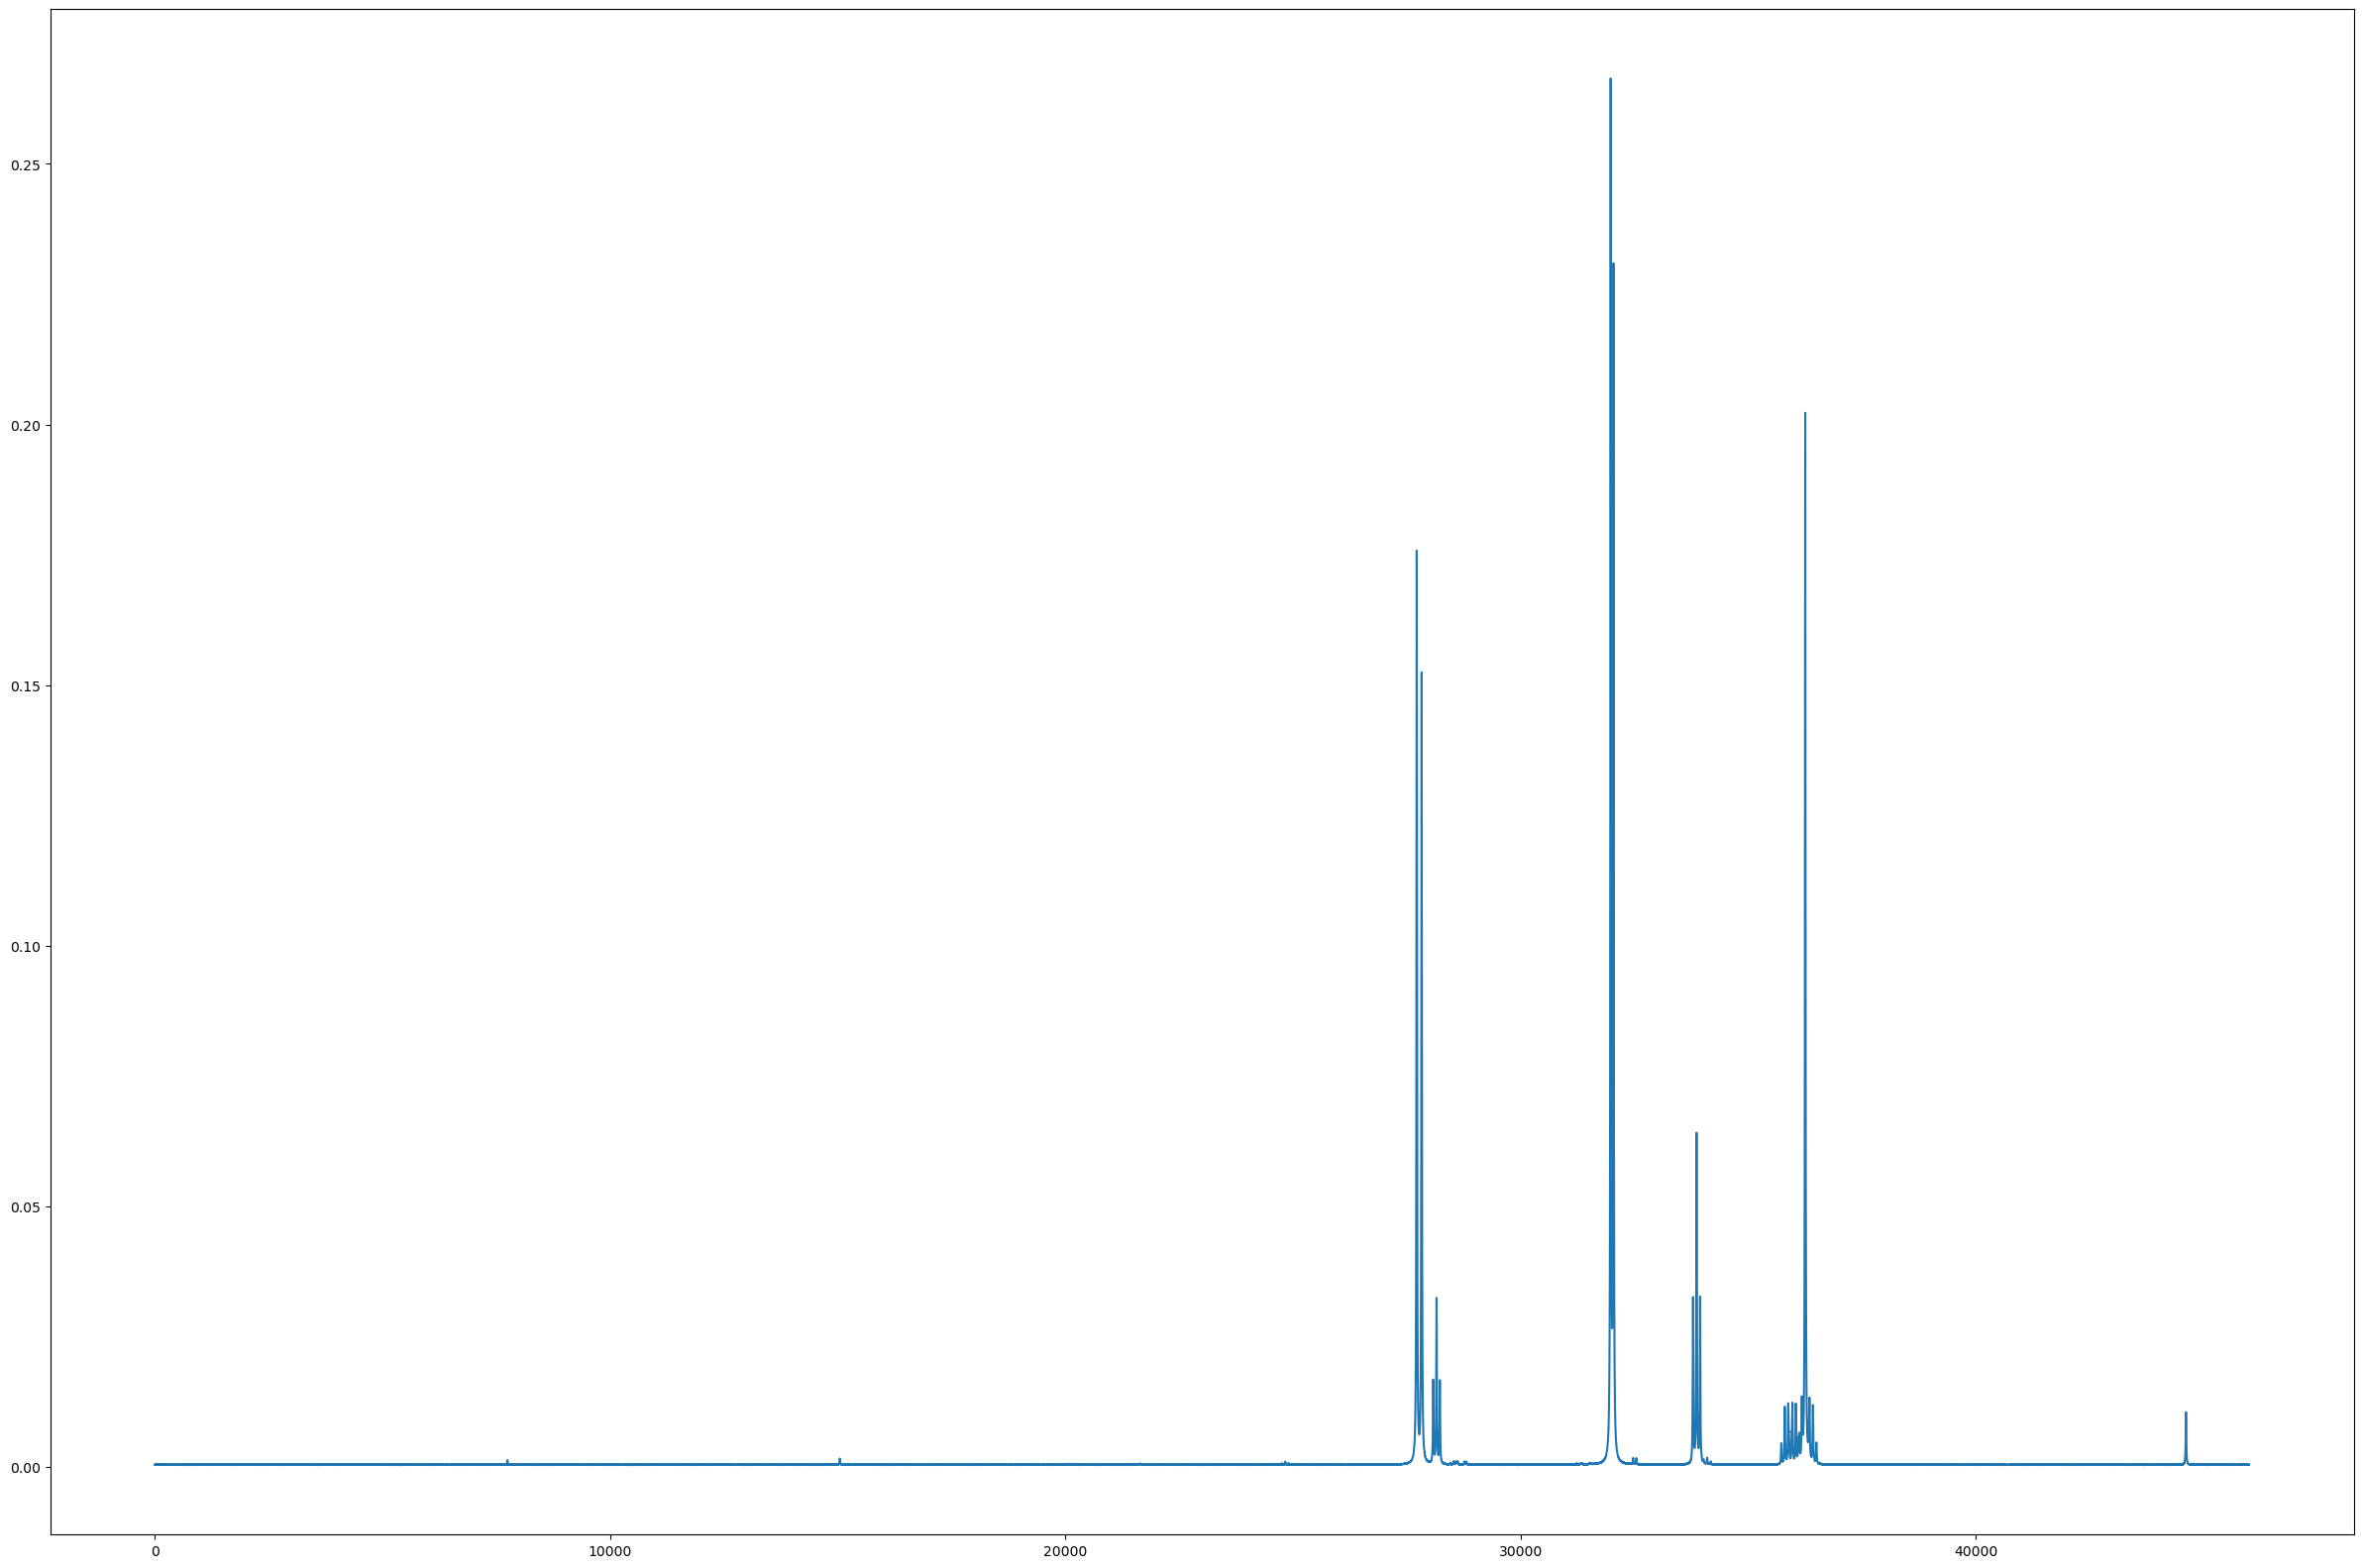

In [7]:
plt.plot(spectra_memmap[200000])

In [8]:
from torch.cuda.amp import GradScaler, autocast


def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr = 2.067749078763321e-05, weight_decay=0.004990448395463014)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping
    accumulation_steps = 4
    
    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        ## Training phase
        # Instantiate the GradScaler
        scaler = GradScaler()
        optimizer.zero_grad()  # Only zero gradients here at the start of an epoch
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Enable autocasting for forward and backward passes
            with autocast():
                outputs = model(inputs.unsqueeze(2))
                loss = criterion(outputs, labels)
                # Scale the loss to account for the accumulation steps
                loss = loss / accumulation_steps
            train_loss += loss.item() * inputs.size(0)
            # Scale the loss and perform backpropagation
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Step the optimizer and update the scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Zero gradients after accumulation_steps

        # Testing phase
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs.unsqueeze(2))
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
        
        
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.AdamW(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [9]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 22687.1910, Test Loss: 10369.5284
Epoch time:  316.41800236701965
Epoch [2/500], Train Loss: 6480.0790, Test Loss: 2657.8458
Epoch time:  276.33479619026184
Epoch [3/500], Train Loss: 1389.0022, Test Loss: 1025.6821
Epoch time:  313.8678822517395
Epoch [4/500], Train Loss: 1082.2447, Test Loss: 990.0864
Epoch time:  273.1220865249634
Epoch [5/500], Train Loss: 994.9839, Test Loss: 972.2735
Epoch time:  286.30682921409607
Epoch [6/500], Train Loss: 847.9388, Test Loss: 876.1393
Epoch time:  294.9248561859131
Epoch [7/500], Train Loss: 763.5150, Test Loss: 1126.1877
Epoch time:  278.37423634529114
Epoch [8/500], Train Loss: 731.4343, Test Loss: 864.4674
Epoch time:  233.9039855003357
Epoch [9/500], Train Loss: 670.8442, Test Loss: 627.9522
Epoch time:  114.51777338981628
Epoch [10/500], Train Loss: 620.5799, Test Loss: 564.0813
Epoch time:  115.60127186775208
Epoch [11/500], Train Loss: 595.1836, Test Loss: 625.

Epoch [92/500], Train Loss: 205.9428, Test Loss: 198.9275
Epoch time:  114.74519896507263
Epoch [93/500], Train Loss: 209.9261, Test Loss: 212.9022
Epoch time:  114.63426303863525
Epoch [94/500], Train Loss: 211.5050, Test Loss: 246.5413
Epoch time:  114.64651560783386
Epoch [95/500], Train Loss: 211.5613, Test Loss: 225.3989
Epoch time:  114.76028490066528
Epoch [96/500], Train Loss: 205.9596, Test Loss: 210.0422
Epoch time:  114.7157130241394
Epoch [97/500], Train Loss: 208.0499, Test Loss: 201.2425
Epoch time:  114.73249316215515
Epoch [98/500], Train Loss: 204.7073, Test Loss: 226.5880
Epoch time:  123.2004325389862
Epoch [99/500], Train Loss: 206.8458, Test Loss: 230.1486
Epoch time:  117.14843082427979
Epoch [100/500], Train Loss: 206.1554, Test Loss: 197.7500
Epoch time:  115.22432231903076
Epoch [101/500], Train Loss: 206.7166, Test Loss: 242.2177
Epoch time:  114.71469497680664
Epoch [102/500], Train Loss: 204.5056, Test Loss: 208.3646
Epoch time:  114.80062747001648
Epoch [10

Epoch [183/500], Train Loss: 165.3627, Test Loss: 167.6069
Epoch time:  341.7514977455139
Epoch [184/500], Train Loss: 166.4148, Test Loss: 170.3659
Epoch time:  367.5832118988037
Epoch [185/500], Train Loss: 169.6761, Test Loss: 180.5981
Epoch time:  388.9622104167938
Epoch [186/500], Train Loss: 168.4802, Test Loss: 181.1735
Epoch time:  385.8068473339081
Epoch [187/500], Train Loss: 165.4792, Test Loss: 159.4353
Epoch time:  380.4220254421234
Epoch [188/500], Train Loss: 167.5605, Test Loss: 161.9843
Epoch time:  403.3245368003845
Epoch [189/500], Train Loss: 167.9769, Test Loss: 163.2777
Epoch time:  384.6775019168854
Epoch [190/500], Train Loss: 166.0382, Test Loss: 160.5259
Epoch time:  390.6225574016571
Epoch [191/500], Train Loss: 171.0516, Test Loss: 158.7195
Epoch time:  388.5043625831604
Epoch [192/500], Train Loss: 166.1921, Test Loss: 173.9340
Epoch time:  383.7001099586487
Epoch [193/500], Train Loss: 166.3260, Test Loss: 154.6751
Epoch time:  434.7759301662445
Epoch [194

Epoch [274/500], Train Loss: 148.9895, Test Loss: 140.6965
Epoch time:  817.6061763763428
Epoch [275/500], Train Loss: 150.9448, Test Loss: 170.2856
Epoch time:  823.1899199485779
Epoch [276/500], Train Loss: 146.4193, Test Loss: 149.7584
Epoch time:  772.0420145988464
Epoch [277/500], Train Loss: 148.5678, Test Loss: 146.2019
Epoch time:  741.3812208175659
Epoch [278/500], Train Loss: 148.7175, Test Loss: 139.2811
Epoch time:  769.9577763080597
Epoch [279/500], Train Loss: 147.2816, Test Loss: 155.1349
Epoch time:  789.9351093769073
Epoch [280/500], Train Loss: 147.3973, Test Loss: 136.1744
Epoch time:  729.5194661617279
Epoch [281/500], Train Loss: 144.6550, Test Loss: 149.0621
Epoch time:  680.5453956127167
Epoch [282/500], Train Loss: 146.9371, Test Loss: 165.6005
Epoch time:  667.7661581039429
Epoch [283/500], Train Loss: 146.2896, Test Loss: 167.1103
Epoch time:  671.915956735611
Epoch [284/500], Train Loss: 146.5905, Test Loss: 133.6830
Epoch time:  665.7099876403809
Epoch [285/

Epoch [366/500], Train Loss: 135.3598, Test Loss: 128.7783
Epoch time:  879.6847143173218
Epoch [367/500], Train Loss: 134.1131, Test Loss: 135.8996
Epoch time:  873.8160061836243
Epoch [368/500], Train Loss: 130.1807, Test Loss: 134.4412
Epoch time:  952.2930920124054
Epoch [369/500], Train Loss: 132.5647, Test Loss: 126.9600
Epoch time:  725.0651819705963
Epoch [370/500], Train Loss: 133.4244, Test Loss: 123.3477
Epoch time:  816.5076355934143
Epoch [371/500], Train Loss: 131.5808, Test Loss: 148.7344
Epoch time:  777.4826083183289
Epoch [372/500], Train Loss: 135.9249, Test Loss: 126.6407
Epoch time:  715.624272108078
Epoch [373/500], Train Loss: 134.4462, Test Loss: 130.8891
Epoch time:  691.243257522583
Epoch [374/500], Train Loss: 132.5830, Test Loss: 136.6392
Epoch time:  771.978039264679
Epoch [375/500], Train Loss: 134.1177, Test Loss: 163.1273
Epoch time:  876.5650222301483
Epoch [376/500], Train Loss: 131.3073, Test Loss: 148.1325
Epoch time:  778.963098526001
Epoch [377/500

Epoch [457/500], Train Loss: 120.0207, Test Loss: 132.0764
Epoch time:  265.0945608615875
Epoch [458/500], Train Loss: 120.3892, Test Loss: 122.1022
Epoch time:  294.0668442249298
Epoch [459/500], Train Loss: 120.4343, Test Loss: 118.1757
Epoch time:  294.3512170314789
Epoch [460/500], Train Loss: 122.0919, Test Loss: 111.5492
Epoch time:  284.2815783023834
Epoch [461/500], Train Loss: 121.9311, Test Loss: 115.7607
Epoch time:  293.1828191280365
Epoch [462/500], Train Loss: 119.4121, Test Loss: 121.7531
Epoch time:  259.54112362861633
Epoch [463/500], Train Loss: 121.3991, Test Loss: 115.0013
Epoch time:  274.80488777160645
Epoch [464/500], Train Loss: 122.0897, Test Loss: 112.0867
Epoch time:  307.47100043296814
Epoch [465/500], Train Loss: 120.7588, Test Loss: 116.2001
Epoch time:  313.5331358909607
Epoch [466/500], Train Loss: 118.9081, Test Loss: 154.0788
Epoch time:  287.7577254772186
Epoch [467/500], Train Loss: 120.8858, Test Loss: 119.2117
Epoch time:  296.3318061828613
Epoch [

In [10]:
np.array(test_losses).min()

110.00104810576886

In [11]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset8_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset8_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_8met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_8met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_8met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_8met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_8met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_8met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_8met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_8met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_8met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_8met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_8met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_8met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_8met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_8met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_8met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_8met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_8met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_8met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_8met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_8met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [12]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

NMR_Model_Aq(
  (conv1): Conv1d(1, 35, kernel_size=(10,), stride=(4,), padding=(1,))
  (conv2): Conv1d(35, 35, kernel_size=(10,), stride=(4,), padding=(1,))
  (conv3): Conv1d(35, 35, kernel_size=(10,), stride=(4,), padding=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25095, out_features=233, bias=True)
  (fc2): Linear(in_features=233, out_features=8, bias=True)
)

In [14]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0).unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  10.760277064488275


In [15]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
86.46  - Concentrations: 0.004999999888241291
95.5  - Concentrations: 0.02500000037252903
87.4  - Concentrations: 0.10000000149011612
84.4  - Concentrations: 0.25
84.62  - Concentrations: 0.5
84.6  - Concentrations: 1.0
84.5  - Concentrations: 2.5
84.36  - Concentrations: 10.0
84.34  - Concentrations: 20.0


In [16]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  0.14583758
--------------------
0.1  - Min Value: 1.8406  - Mean Value: 10.2
0.54  - Min Value: 0.3771  - Mean Value: 11.0
0.1  - Min Value: 3.4576  - Mean Value: 11.6
0.12  - Min Value: 1.4371  - Mean Value: 6.6
0.17  - Min Value: 1.6178  - Mean Value: 11.4
0.08  - Min Value: 4.1236  - Mean Value: 12.4
0.1  - Min Value: 1.3767  - Mean Value: 10.2
0.11  - Min Value: 4.7076  - Mean Value: 12.2
0.07  - Min Value: 3.7959  - Mean Value: 11.8
0.08  - Min Value: 2.6395  - Mean Value: 10.5


In [17]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  2.94983
--------------------
3.01  - Min Value: 0.0228  - Mean Value: 0.1
7.94  - Min Value: 0.0054  - Mean Value: 0.1
2.5  - Min Value: 0.0267  - Mean Value: 0.1
1.4  - Min Value: 0.0371  - Mean Value: 0.1
1.59  - Min Value: 0.0507  - Mean Value: 0.1
4.07  - Min Value: 0.0052  - Mean Value: 0.1
2.58  - Min Value: 0.0341  - Mean Value: 0.1
3.39  - Min Value: 0.0149  - Mean Value: 0.1
0.87  - Min Value: 0.0726  - Mean Value: 0.2
2.15  - Min Value: 0.0367  - Mean Value: 0.1


In [18]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  2.482538
--------------------
1.98  - Min Value: 0.0179  - Mean Value: 0.5
1.8  - Min Value: 0.0264  - Mean Value: 1.2
1.79  - Min Value: 0.0488  - Mean Value: 0.7
5.84  - Min Value: 0.0103  - Mean Value: 0.2
3.62  - Min Value: 0.0237  - Mean Value: 0.6
6.77  - Min Value: 0.006  - Mean Value: 0.8
0.59  - Min Value: 0.0609  - Mean Value: 1.2
1.33  - Min Value: 0.0462  - Mean Value: 0.5
0.39  - Min Value: 0.0353  - Mean Value: 2.7
0.71  - Min Value: 0.1399  - Mean Value: 1.1


In [19]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  367.73386
--------------------
489.9  - Min Value: 0.0323  - Mean Value: 0.7
403.01  - Min Value: 0.0323  - Mean Value: 0.7
487.39  - Min Value: 0.0323  - Mean Value: 0.9
635.56  - Min Value: 0.0323  - Mean Value: 0.6
253.71  - Min Value: 0.0323  - Mean Value: 0.8
447.56  - Min Value: 0.0323  - Mean Value: 1.3
347.51  - Min Value: 0.0323  - Mean Value: 0.9
273.0  - Min Value: 0.0323  - Mean Value: 0.6
90.08  - Min Value: 0.0323  - Mean Value: 0.9
249.63  - Min Value: 0.0324  - Mean Value: 1.1


In [22]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  8.212171
--------------------
12.05  - Min Value: 0.0067  - Mean Value: 2.5
5.95  - Min Value: 0.0095  - Mean Value: 3.6
5.83  - Min Value: 0.0109  - Mean Value: 0.1
13.28  - Min Value: 0.0078  - Mean Value: 8.7
3.48  - Min Value: 0.029  - Mean Value: 6.1
2.93  - Min Value: 0.021  - Mean Value: 8.6
4.69  - Min Value: 0.0473  - Mean Value: 6.9
17.12  - Min Value: 0.0055  - Mean Value: 9.5
13.04  - Min Value: 0.02  - Mean Value: 6.0
3.76  - Min Value: 0.0415  - Mean Value: 5.5


In [21]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x29190 and 25095x233)

In [23]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  85.8453055973663
--------------------
84.86
84.99
85.01
84.99
85.76
85.85
85.92
86.97
87.44
86.68


In [24]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  73.10043324564778
--------------------
82.49
76.42
70.51
66.67
65.68
67.39
70.26
73.15
76.96
81.46


In [25]:
Pred = model_aq(OtherValSpectra[0].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 1s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.7191, 1.1480, 0.3818, 1.6846, 0.8900, 0.8150, 0.7971, 1.0269],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.5799, 0.8592, 0.0000, 1.8067, 0.7731, 0.8847, 0.6577, 0.4835],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 1s and 20s
tensor([ 0.0000, 19.7999,  0.0000, 19.8230,  0.0730, 19.7280,  0.0000, 19.5708],
       device='cuda:0', grad_fn=<SelectBackward0>)
HD-Range 2 - 0s and 20s
tensor([ 0.0000, 19.8016,  0.0000, 19.8239,  0.0650, 19.7267,  0.0000, 19.5728],
       device='cuda:0', grad_fn=<SelectBackward0>)
